<a href="https://colab.research.google.com/github/prislewarz/GoogleSolutionChallenge2023/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from numpy import dot
from numpy.linalg import norm
from scipy import stats
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.8 MB/s eta 0:00:00


Mounted at /content/drive


<ipython-input-7-629921dedc26>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = new_csv_data['final_label'], palette = "husl",  ax = ax)


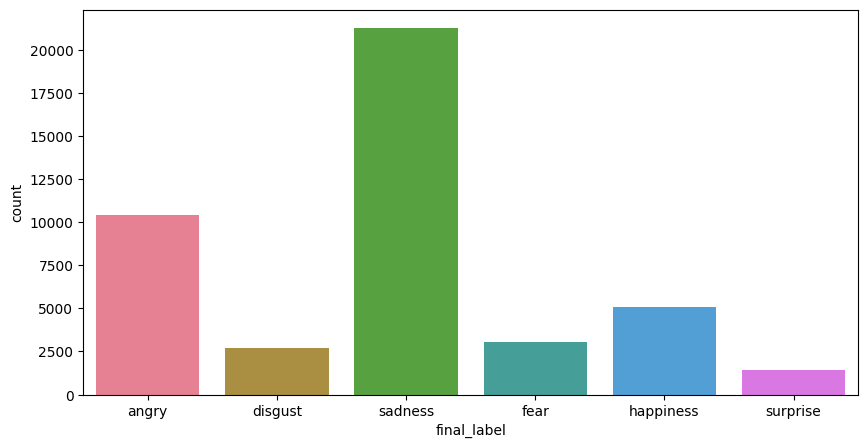

In [7]:
from google.colab import drive
drive.mount('/content/drive')

csv_data_1 = pd.read_csv('/content/drive/MyDrive/5th.csv', encoding='CP949')
csv_data_2 = pd.read_csv('/content/drive/MyDrive/4th.csv', encoding='CP949')
csv_data_3 = pd.read_csv('/content/drive/MyDrive/5th_2.csv', encoding='CP949')
csv_data = pd.concat([csv_data_1, csv_data_2, csv_data_3], ignore_index=True)

csv_data['1번 감정'] = csv_data['1번 감정'].apply(str.lower)
csv_data['2번 감정'] = csv_data['2번 감정'].apply(str.lower)
csv_data['3번 감정'] = csv_data['3번 감정'].apply(str.lower)
csv_data['4번 감정'] = csv_data['4번 감정'].apply(str.lower)
csv_data['5번 감정'] = csv_data['5번 감정'].apply(str.lower)

def get_keys(dic): #returns a key for max values in dic
  key_list = list(dic.keys())
  val_list = list(dic.values())
  pos = val_list.index(max(val_list))
  return key_list[pos]

final_label = []
for i in range(len(csv_data)):
  sentiments = {'angry':0, 'sadness':0, 'happiness':0, 'fear': 0, 'disgust':0, 'surprise':0, 'neutral':0}
  sentiments[csv_data.iloc[i]['1번 감정']] += csv_data.iloc[i]['1번 감정세기']
  sentiments[csv_data.iloc[i]['2번 감정']] += csv_data.iloc[i]['2번 감정세기']
  sentiments[csv_data.iloc[i]['3번 감정']] += csv_data.iloc[i]['3번 감정세기']
  sentiments[csv_data.iloc[i]['4번 감정']] += csv_data.iloc[i]['4번감정세기']
  sentiments[csv_data.iloc[i]['5번 감정']] += csv_data.iloc[i]['5번 감정세기']

  final_label.append(get_keys(sentiments))

final_label_df = pd.DataFrame(final_label, columns=['final_label'])
new_csv_data = pd.concat([csv_data[['wav_id', '발화문']], final_label_df], axis = 1)

class_counts = new_csv_data['final_label'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = new_csv_data['final_label'], palette = "husl",  ax = ax)
plt.show()


In [8]:
path = '/content/drive/MyDrive/4th_wav/5e2ac3d55807b852d9e01fd6.wav'
data, sr = librosa.load(path)

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

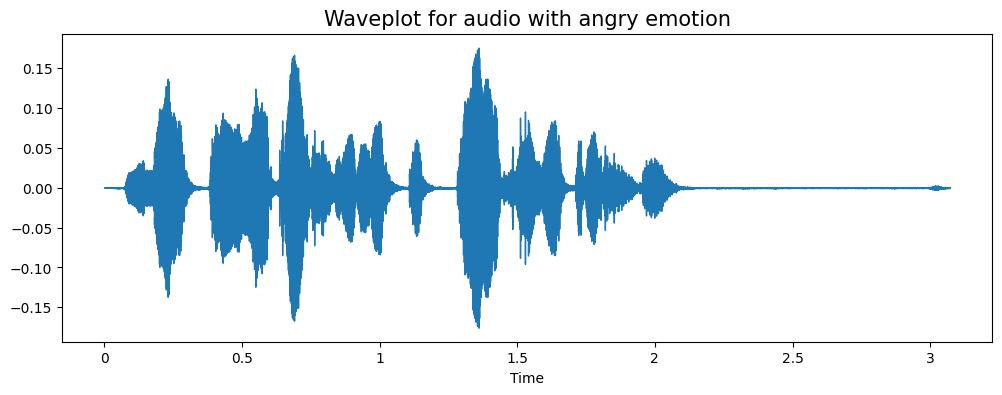

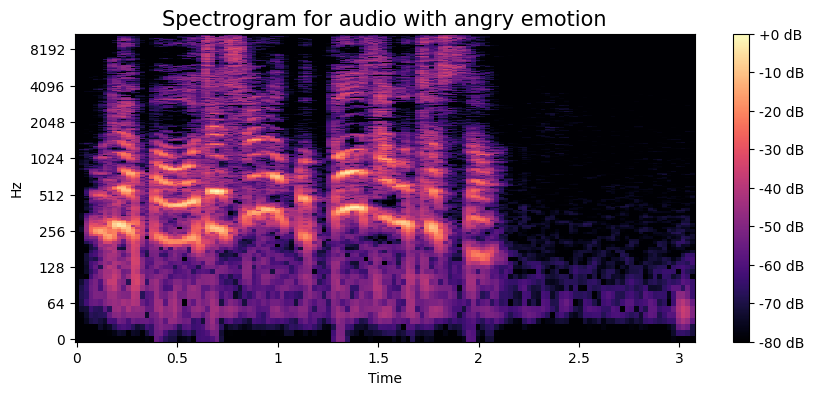

In [9]:
emotion = 'angry'
sadness_data = new_csv_data[new_csv_data['final_label'] == emotion]

file_name = sadness_data.iloc[0]['wav_id']

path = '/content/drive/MyDrive/4th_wav/5e2ac3d55807b852d9e01fd6.wav'
data, sr = librosa.load(path)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr)
plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
plt.show()

D = librosa.stft(data)
spectrogram = np.abs(D)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
plt.show()

In [10]:
folder_paths = ['/content/drive/MyDrive/5th_wav', '/content/drive/MyDrive/4th_wav', '/content/drive/MyDrive/5th_2_wav']
balanced_file_list = csv_data['wav_id'].tolist()

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
def extract_features(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

In [13]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result

In [ ]:
X = []  # 각 파일의 특성을 저장할 리스트
Y = []  # 레이블을 저장할 리스트

for folder in folder_paths:
    for file_name in os.listdir(folder):
        if file_name.endswith('.wav') and file_name[:-4] in balanced_file_list:
            file_path = os.path.join(folder, file_name)
            data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
            x = np.array(extract_features(data)).reshape(1, -1)
            x = np.expand_dims(x, axis=2)
            x = x.flatten()

            file_id = file_name[:-4]  # '.wav'를 제외한 부분
            emotion = (new_csv_data.loc[new_csv_data['wav_id'] == file_id, 'final_label'].values[0])

            X.append(x)  # 특성 저장
            Y.append(emotion)  # 레이블 저장

X = np.array(X)
Y = np.array(Y)

Features = pd.DataFrame(X)
Features['labels'] = Y

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = Features.iloc[:, :-1].values
Y = Features['labels']

Y = [labels[0] for labels in Y]
Y = np.array(Y).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((12571, 149, 1), (12571, 5), (4191, 149, 1), (4191, 5))

In [ ]:
model = Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

num_emotions = 5
model.add(Dense(num_emotions, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 149, 256)          1536      
                                                                 
 batch_normalization (Batch  (None, 149, 256)          1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 75, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 128)           163968    
                                                                 
 batch_normalization_1 (Bat  (None, 75, 128)           5

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000005, verbose=1)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
197/197 [==============================] - 16s 23ms/step - loss: 0.5107 - accuracy: 0.4175 - val_loss: 0.5070 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 2s 10ms/step - loss: 0.4556 - accuracy: 0.4461 - val_loss: 0.4669 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 2s 10ms/step - loss: 0.4497 - accuracy: 0.4464 - val_loss: 0.4411 - val_accuracy: 0.4488 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 2s 12ms/step - loss: 0.4475 - accuracy: 0.4500 - val_loss: 0.4376 - val_accuracy: 0.4514 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 2s 11ms/step - loss: 0.4466 - accuracy: 0.4489 - val_loss: 0.4377 - val_accuracy: 0.4493 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 2s 10ms/step - loss: 0.4433 - accuracy: 0.4524 - val_loss: 0.4373 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 2s

131/131 [==============================] - 1s 3ms/step - loss: 0.4362 - accuracy: 0.4844
Accuracy of our model on test data :  48.437127470970154 %


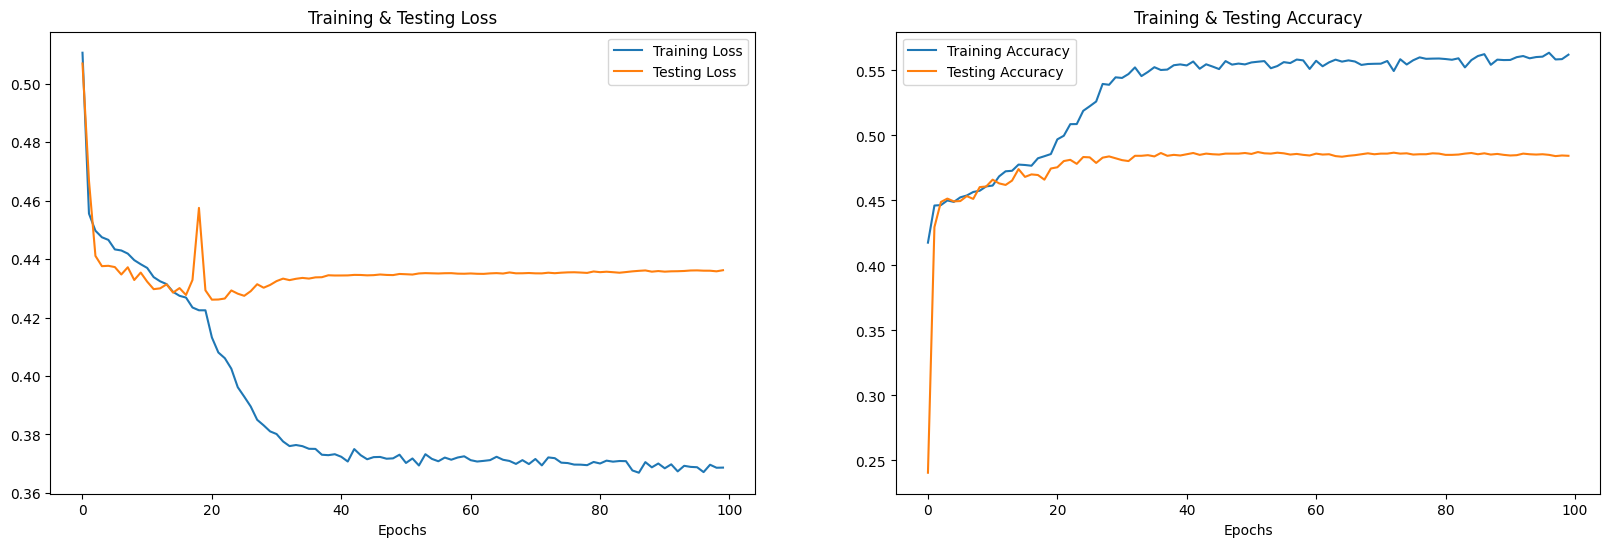

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# 테스트데이터 적용
pred_test = model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)
y_test2 = encoder.inverse_transform(y_test)

131/131 [==============================] - 1s 4ms/step


In [ ]:
y_pred_numeric = np.argmax(y_pred, axis=1)
y_test_numeric = np.argmax(y_test2, axis=1)

y_pred_onehot = np.eye(num_emotions)[y_pred_numeric]
y_test_onehot = np.eye(num_emotions)[y_test_numeric]

y_pred_labels = encoder.inverse_transform(y_pred_onehot)
y_test_labels = encoder.inverse_transform(y_test_onehot)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels.flatten()
df['Actual Labels'] = y_test_labels.flatten()

df.head(5)

,Predicted Labels,Actual Labels
0,a,a
1,a,a
2,a,a
3,a,a
4,a,a


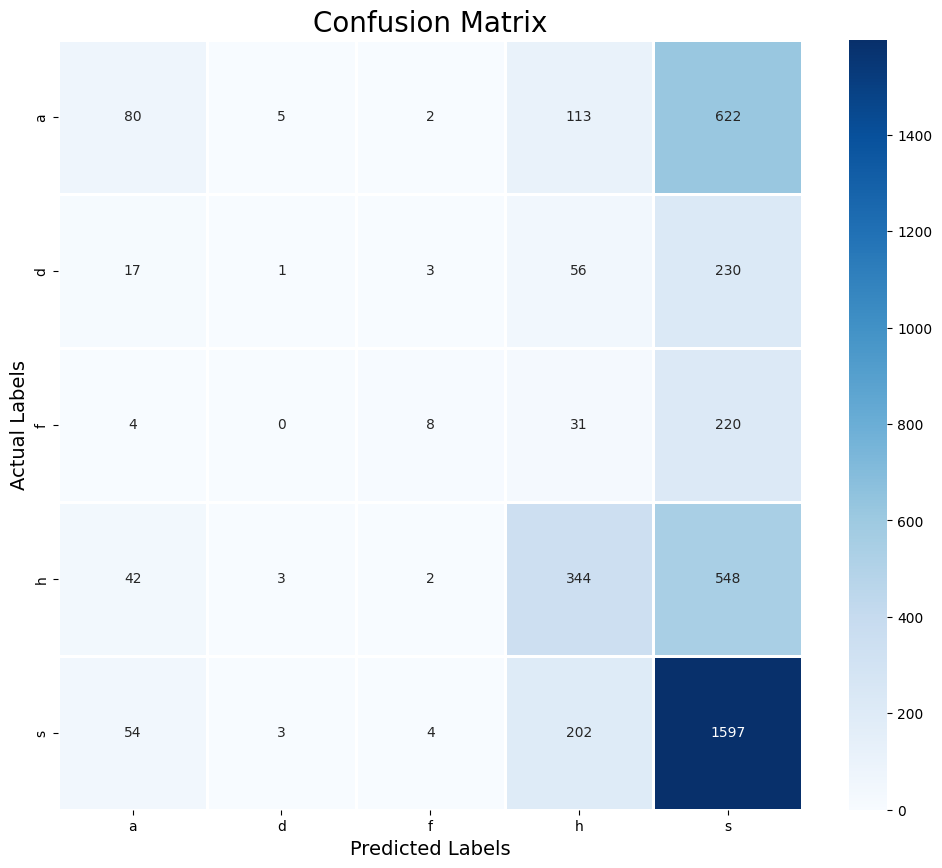

In [ ]:
cm = confusion_matrix(y_test2, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           a       0.41      0.10      0.16       822
           d       0.08      0.00      0.01       307
           f       0.42      0.03      0.06       263
           h       0.46      0.37      0.41       939
           s       0.50      0.86      0.63      1860

    accuracy                           0.48      4191
   macro avg       0.37      0.27      0.25      4191
weighted avg       0.44      0.48      0.41      4191

